### Classical Base Model: MNIST Data

Here, we experiment with a model with basic CNN layers and classical contrastive pair loss to make the model predict whether 2 images belong to the same class or different class.

We will make pairs of images, if they belong to the same class the label will be set to 1, otherwise 0. The model's goal will be to predict the label correctly.

We will consider only images of 0 and 1 from MNIST dataset, as the datasets we will use later on are also binary (electron-photon or quark-gluon)

In [45]:
# Required Imports
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras import layers, models, losses, optimizers
import pandas as pd
import itertools

### Data Loading and Pre-processing

In [2]:
# loading the data as train and test
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


In [3]:
# Filter for only 0 and 1 from all the digits
def filter_labels(images, labels):
    filter_mask = np.isin(labels, [0, 1])
    return images[filter_mask], labels[filter_mask]

In [4]:
x_train, y_train = filter_labels(x_train, y_train)
x_test, y_test = filter_labels(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(12665, 28, 28) (2115, 28, 28)
(12665,) (2115,)


In [5]:
# Preprocess the dataset
def preprocess_data(images, labels):
    images = np.expand_dims(images, -1)  # Add channel dimension
    images = images.astype('float32') / 255.0  # Normalize
    return images, labels

In [6]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(12665, 28, 28, 1) (2115, 28, 28, 1)
(12665,) (2115,)


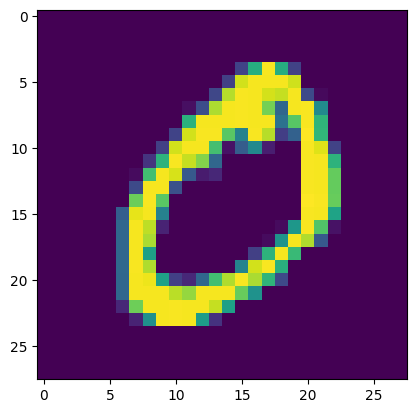

In [7]:
plt.imshow(x_train[0])

In [8]:
# Saving the data as npz
np.savez_compressed('../data/mnist01.npz', **{
    'x_train': x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test
})

### Defining the Model

In [9]:
# Create pairs of images and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels)) # 2
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for idx1 in range(len(images)):
        x1, label1 = images[idx1], labels[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = images[idx2]

        # if x1==x2, label set to 1
        pairs.append([x1, x2])
        pair_labels.append(1)

        # if x1!=x2, label set to 0
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [10]:
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape,labels_test.shape)

(25330, 2, 28, 28, 1) (4230, 2, 28, 28, 1)
(25330,) (4230,)


In [13]:
def plot_sample_pairs(pairs, labels, num_samples=3):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(28, 28), cmap='gray')
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

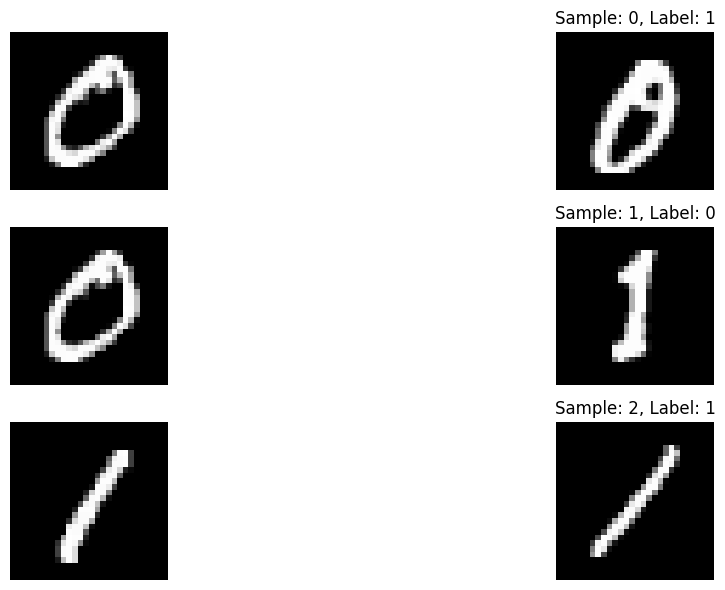

In [14]:
plot_sample_pairs(pairs_train, labels_train)

## Contrastive Pair Loss

The contrastive pair loss is used to learn representations by contrasting positive and negative pairs of samples. 

The formula is given by:

$$
L = \frac{1}{2N} \sum_{i=1}^{N} \left[ y_i \cdot d_i^2 + (1 - y_i) \cdot \max(margin - d_i, 0)^2 \right]
$$

where:

- **L** is the contrastive loss
- **N** is the number of pairs
- **$y_i$** is a binary label indicating whether the pair ($x_i$, $x_j$) is a positive pair (1) or a negative pair (0)
- **$d_i$** is the distance between the embeddings of the pair ($x_i$, $x_j$)
- **margin** is a predefined margin

In this formula:

- For positive pairs $y_i$ = 1, the loss encourages the distance $d_i$ to be small
- For negative pairs $y_i$ = 0, the loss encourages the distance $d_i$ to be larger than the margin

This helps in clustering positive pairs together and pushing negative pairs apart when creating their embeddings


In [15]:
# Contrastive loss function based on margin
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

In [16]:
# Define the CNN model 
def create_base_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu')) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 2
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 3
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

In [28]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])
    
    model = models.Model([input_0, input_1], distance)
    
    return model, processed_0, processed_1

In [29]:
# Define the model
input_shape = pairs_train.shape[2:]
siamese_network, processed_0, processed_1 = create_siamese_network(input_shape)

# Compile the model
siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam())

# Train the model
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 73s 88ms/step - loss: 0.0112 - val_loss: 0.0021
Epoch 2/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 3/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - loss: 6.7669e-04 - val_loss: 0.0018
Epoch 4/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - loss: 2.5559e-04 - val_loss: 0.0017
Epoch 5/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - loss: 1.1833e-04 - val_loss: 0.0016
Epoch 6/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - loss: 1.1249e-04 - val_loss: 0.0015
Epoch 7/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - loss: 2.1915e-04 - val_loss: 0.0015
Epoch 8/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 90s 96ms/step - loss: 1.2169e-04 - val_loss: 0.0014
Epoch 9/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - loss: 2.8865e-04 - val_loss: 0.0013
Epoch 10/10
792/792 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - loss: 5.5706e-05 - val_loss: 0.0012


In [30]:
siamese_network.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_8 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 1)                 │         514,561 │ input_layer_7[0][0],       │
│                               │                           │                 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_3 (Lambda)             │ (None)                    │               0 │ sequential_2[0][0],        │
│                               │                           │                 │ sequential_2[1][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,543,685 (5.89 MB)

 Trainable params: 514,561 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,029,124 (3.93 MB)

In [33]:
processed_0, processed_1

(<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_90>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_91>)

<Axes: title={'center': 'Learning History'}>

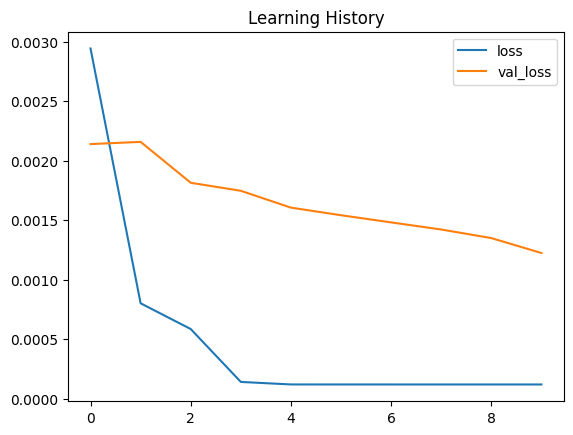

In [34]:
pd.DataFrame(history.history).plot(title="Learning History")

### Evaluation of the model

In [35]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


In [36]:
distance

array([1.0907650e-05, 9.9998909e-01, 4.1934095e-11, ..., 1.0000000e+00,
       4.7683716e-07, 9.9999952e-01], dtype=float32)

In [37]:
def distances_to_labels(distances, threshold=0.5):
    return (distances < threshold).astype(int)

In [38]:
y_pred = distances_to_labels(distance)

In [39]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(28, 28), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        plt.title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    plt.tight_layout()
    plt.show()

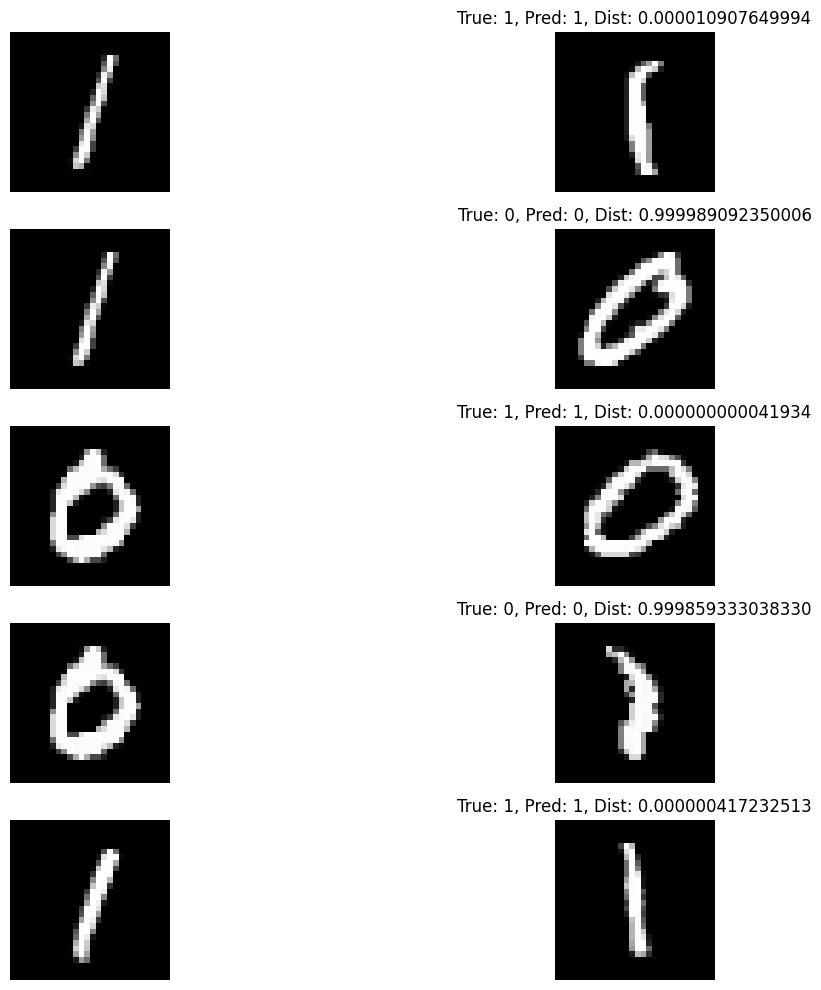

In [40]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, num_samples=5)

In [41]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

In [42]:
evaluate_precision_recall_accuracy(labels_test,y_pred)

(0.998109640831758, 0.9985815602836879, 0.9983451536643027)

In [43]:
def confusion_matrix(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    return np.array([[true_negatives, false_positives],
                     [false_negatives, true_positives]])

In [44]:
confusion_matrix(labels_test,y_pred)

array([[2111,    4],
       [   3, 2112]])

In [46]:
def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):
  cm = confusion_matrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix
  n_class = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix", 
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_class),
        yticks=np.arange(n_class),
        xticklabels=labels,
        yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)


  threshold = (cm.max()+cm.min())/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",
            horizontalalignment="center",
            color="white" if cm[i,j]>threshold else "black",
            size=text_size)

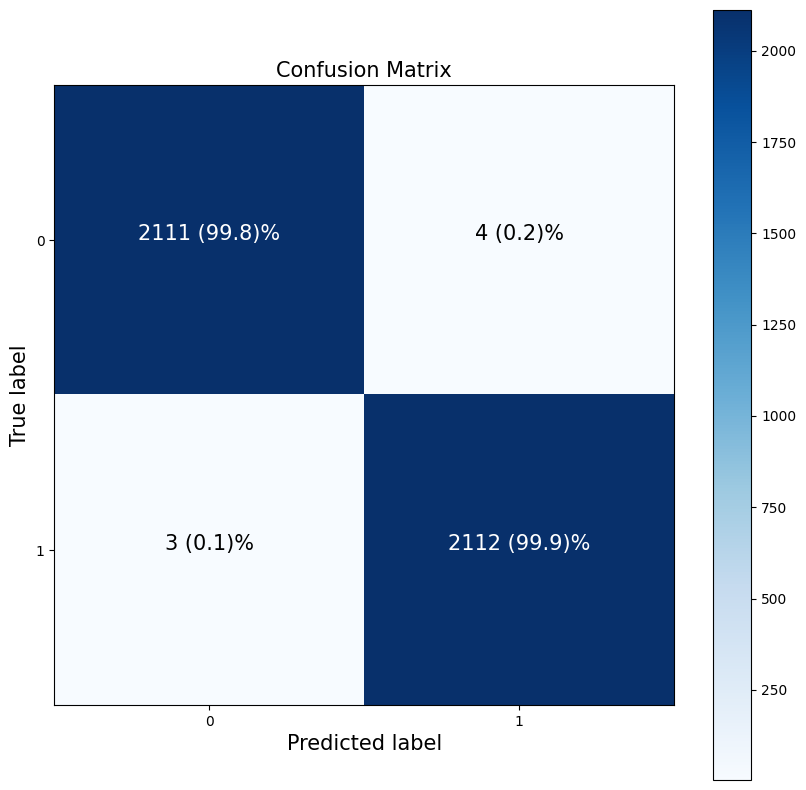

In [49]:
make_cm(labels_test,y_pred,["0","1"])

In [50]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


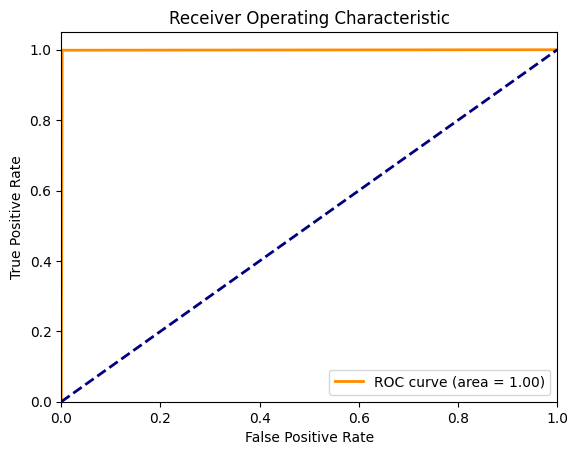

In [51]:
plot_auc(labels_test,y_pred)

In [64]:
# save the model
saved_model_path = '../saved_models/classical_base_model_1.keras'
siamese_network.save(saved_model_path)
# Load the model
loaded_model = tf.keras.models.load_model(saved_model_path, safe_mode=False)
# Verify
loaded_model.summary()

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=(['<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_260>', '<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_262>'],)
  • kwargs={'mask': ['None', 'None']}